In [1]:
import os
import numpy as np
import matplotlib
matplotlib.use('Agg')           
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from tensorflow import keras

input_shape = (28, 28, 1)
num_classes = 10
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 128

In [2]:
print('\nLoading MNIST')

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_train = x_train.astype(np.float32) / 255
x_test = np.expand_dims(x_test, -1)
x_test = x_test.astype(np.float32) / 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('\nSpliting data')

ind = np.random.permutation(x_train.shape[0])
x_train, y_train = x_train[ind], y_train[ind]
n = int(x_train.shape[0] * (1-VALIDATION_SPLIT))
x_val = x_train[n:]
y_val = y_train[n:]
x_train = x_train[:n]
y_train = y_train[:n]


Loading MNIST
11501568/11490434 [==============================] - 0s 0us/step

Spliting data


In [3]:
print('\nConstructing model')
def make_model(input_shape, num_classes, temp=1):
    inputs = keras.Input(shape = input_shape)
    x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(units=128, activation='relu')(x)
    x = keras.layers.Dropout(0.25)(x)
    outputs = keras.layers.Dense(units=num_classes)(x)
    outputs = outputs / temp
    outputs = keras.layers.Activation('softmax')(outputs)
    return keras.Model(inputs, outputs)


Constructing model


In [5]:
model = make_model(input_shape, num_classes)
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
print('\nTraining model')
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=5, validation_data=(x_val, y_val))


Training model
Epoch 1/5
422/422 [==============================] - 7s 15ms/step - loss: 0.2468 - accuracy: 0.9248 - val_loss: 0.0705 - val_accuracy: 0.9768
Epoch 2/5
422/422 [==============================] - 4s 10ms/step - loss: 0.0702 - accuracy: 0.9792 - val_loss: 0.0486 - val_accuracy: 0.9828
Epoch 3/5
422/422 [==============================] - 5s 12ms/step - loss: 0.0471 - accuracy: 0.9850 - val_loss: 0.0377 - val_accuracy: 0.9890
Epoch 4/5
422/422 [==============================] - 5s 12ms/step - loss: 0.0371 - accuracy: 0.9883 - val_loss: 0.0338 - val_accuracy: 0.9887
Epoch 5/5
422/422 [==============================] - 5s 13ms/step - loss: 0.0299 - accuracy: 0.9902 - val_loss: 0.0360 - val_accuracy: 0.9892


In [17]:
def fgmt(model, x, y=None, eps=0.01, epochs=1, sign=True, clip_min=0.,
         clip_max=1.):
    
    y_pred = model.predict(x)
    target = keras.utils.to_categorical(y, num_classes)
    if y is None:
        indices = tf.argmin(y_pred, axis=1)
        target = keras.utils.to_categorical(indices, num_classes)
   
    x_adv = tf.identity(x)
    while epochs > 0:
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            y_pred = model(x_adv)
            loss = tf.keras.losses.CategoricalCrossentropy()(target, y_pred)
        grads = tape.gradient(loss, x_adv)
        signed_grads = tf.sign(grads)
        x_adv = x_adv - eps * signed_grads
        epochs -= 1

    return x_adv

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[[2.1725659e-12 1.2336783e-09 9.9999988e-01 1.7966677e-11 2.5351095e-15
  5.8377445e-20 1.0921835e-18 1.5207171e-07 4.8201443e-14 7.1581522e-19]]
[[6.9314754e-12 4.7834692e-04 4.4663334e-03 9.9026835e-01 7.8081784e-11
  3.2021991e-10 7.3835042e-11 4.7869035e-03 1.8856248e-09 5.6382702e-12]]


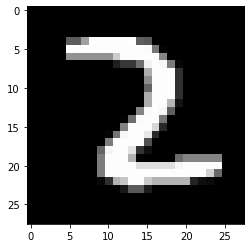

In [19]:
print(y_train[0])
print(model.predict(np.expand_dims(x_train[0], 0)))
plt.imshow(x_train[0, :, :, 0], cmap='gray')
x_adv = fgmt(model, np.expand_dims(x_train[0],0), [3], epochs=18)
print(model.predict(x_adv))

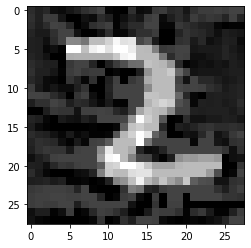

In [20]:
plt.imshow(x_adv[0, :, :, 0], cmap='gray')